# Regression

In [ ]:
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import datasets

import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "FutureWarning")
plt.style.use("dark_background")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

<ipython-input-1-c4ef8f887295>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [ ]:
X, y = make_regression(n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).type_as(train_X)
val_X = torch.from_numpy(X_test).to(torch.float32)
val_y = torch.from_numpy(y_test).type_as(val_X)

In [ ]:
BATCH = 64

train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)
input_features = X.shape[1]

In [ ]:
class Net(nn.Module):
    def __init__(self, input_features):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_features, 64)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.layer5 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU()
        self.layer6 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        x = self.relu4(x)
        x = self.layer5(x)
        x = self.relu5(x)
        x = self.layer6(x)
        return x


In [ ]:
model = Net(input_features=X.shape[1])

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.042)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
# поместить модель на GPU
model = model.to(DEVICE)

losses_train = []
losses_test = []
total_loss = []
lrs = []

# задать общее количество эпох
MAX_EPOCHS = 100
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
  # для каждой части датасета
  for iteration, (X_batch, y_batch) in enumerate(train_loader):
    # ЭТАП ОБУЧЕНИЯ
    # мы переводим модель в режим обучения
    model.train()
    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()
    # пропускам данные через модель
    outputs = model(X_batch.to(DEVICE))
    # выравняем выходы в одномерный тензор
    outputs = outputs.view(-1)
    # считаем лосс
    loss = loss_function(outputs, y_batch.to(DEVICE))
    # делаем шаг в обратном направлении
    loss.backward()
    # собираем лоссы
    losses_train.append(loss.detach().cpu().numpy().item())
    # делаем шаг оптимизатора
    optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr())
  # собираем средний лосс
  total_loss.append(np.mean(losses_train))
  # ШАГ ВАЛИДАЦИИ
  for iteration, (X_batch, y_batch) in enumerate(val_loader):
    # режим инференса или валидации, тестирования
    model.eval()
    # обязательно добавить
    with torch.no_grad():
      outputs = model(X_batch.to(DEVICE))
      outputs = outputs.view(-1)
      loss = loss_function(outputs, y_batch.to(DEVICE))
      losses_test.append(loss.detach().cpu().numpy().item())
      # считаем вероятности
      proba = torch.sigmoid(outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

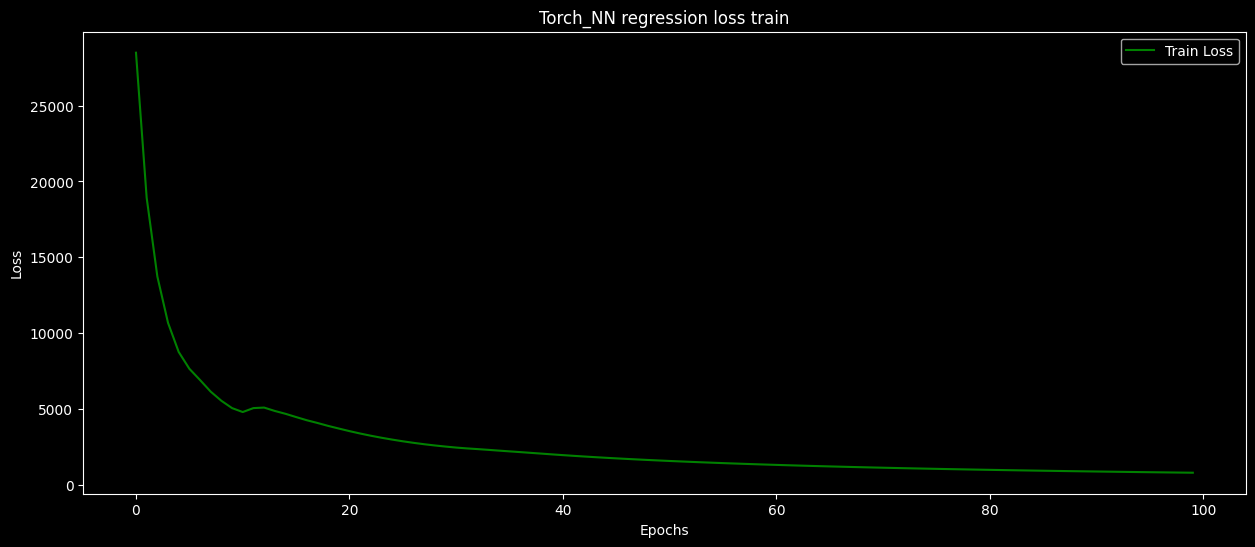

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         label='Train Loss',
         color='g',
         linestyle="-"
         )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Torch_NN regression loss train")
plt.legend()
plt.show()

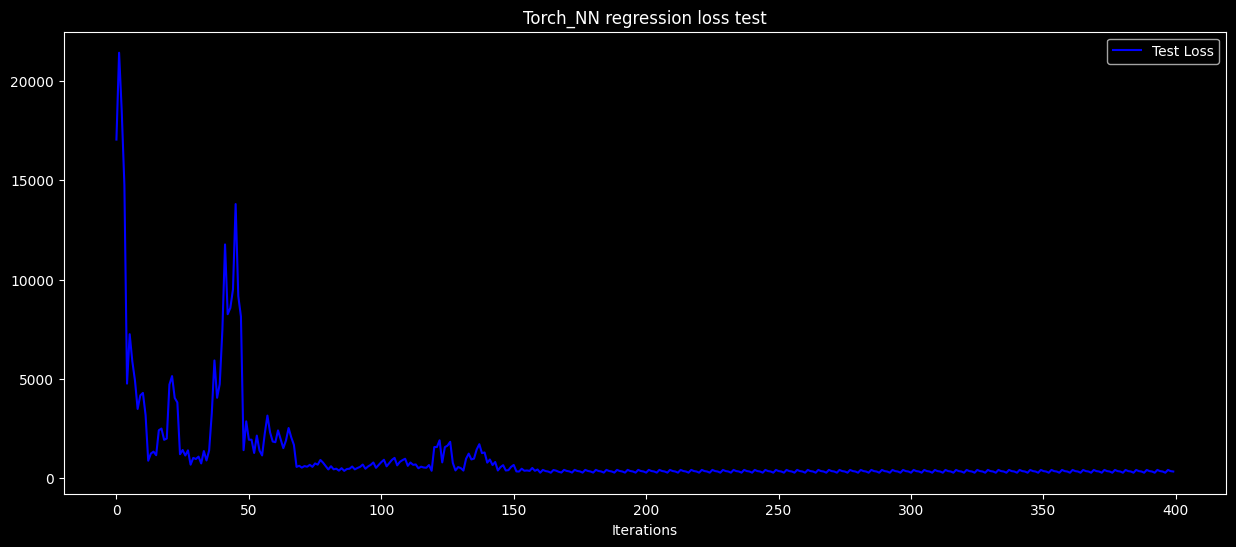

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(losses_test)),
         losses_test,
         label='Test Loss',
         color='b',
         linestyle="-"
         )
plt.title('Test Loss over Iterations')
plt.xlabel('Iterations')
plt.title("Torch_NN regression loss test")
plt.legend()
plt.show()

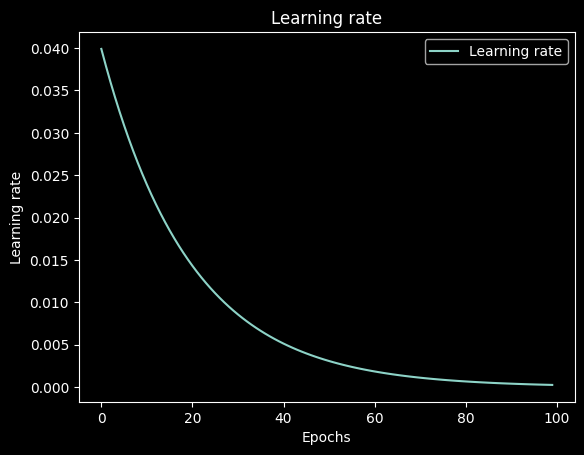

In [ ]:
plt.plot(lrs, label='Learning rate')
plt.title('Learning rate')
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

# Classification

In [ ]:
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "FutureWarning")
plt.style.use("dark_background")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [ ]:
N_CLASSES = 2
X, y = make_classification(n_samples=1000, n_features=20, n_classes=N_CLASSES, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).type_as(train_X)
val_X = torch.from_numpy(X_test).to(torch.float32)
val_y = torch.from_numpy(y_test).type_as(val_X)

In [ ]:
BATCH = 64

train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_features, num_classes):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_features, 64)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

In [ ]:
model = Net(input_features=X.shape[1], num_classes=N_CLASSES)
input_features = X.shape[1]
# model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
# поместить модель на GPU
model = model.to(DEVICE)

losses_train = []
losses_test = []
total_loss = []
lrs = []

# задать общее количество эпох
MAX_EPOCHS = 100
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
  # для каждой части датасета
  for iteration, (X_batch, y_batch) in enumerate(train_loader):
    # ЭТАП ОБУЧЕНИЯ
    # мы переводим модель в режим обучения
    model.train()
    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()
    # пропускам данные через модель
    outputs = model(X_batch.to(DEVICE))
    # выравняем выходы в одномерный тензор
    outputs = outputs.view(-1)
    # считаем лосс
    loss = criterion(outputs, y_batch.to(DEVICE))
    # делаем шаг в обратном направлении
    loss.backward()
    # собираем лоссы
    losses_train.append(loss.detach().cpu().numpy().item())
    # делаем шаг оптимизатора
    optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr())
  # собираем средний лосс
  total_loss.append(np.mean(losses_train))
  # ШАГ ВАЛИДАЦИИ
  for iteration, (X_batch, y_batch) in enumerate(val_loader):
    # режим инференса или валидации, тестирования
    model.eval()
    # обязательно добавить
    with torch.no_grad():
      outputs = model(X_batch.to(DEVICE))
      outputs = outputs.view(-1)
      loss = criterion(outputs, y_batch.to(DEVICE))
      losses_test.append(loss.detach().cpu().numpy().item())

  0%|          | 0/100 [00:00<?, ?it/s]

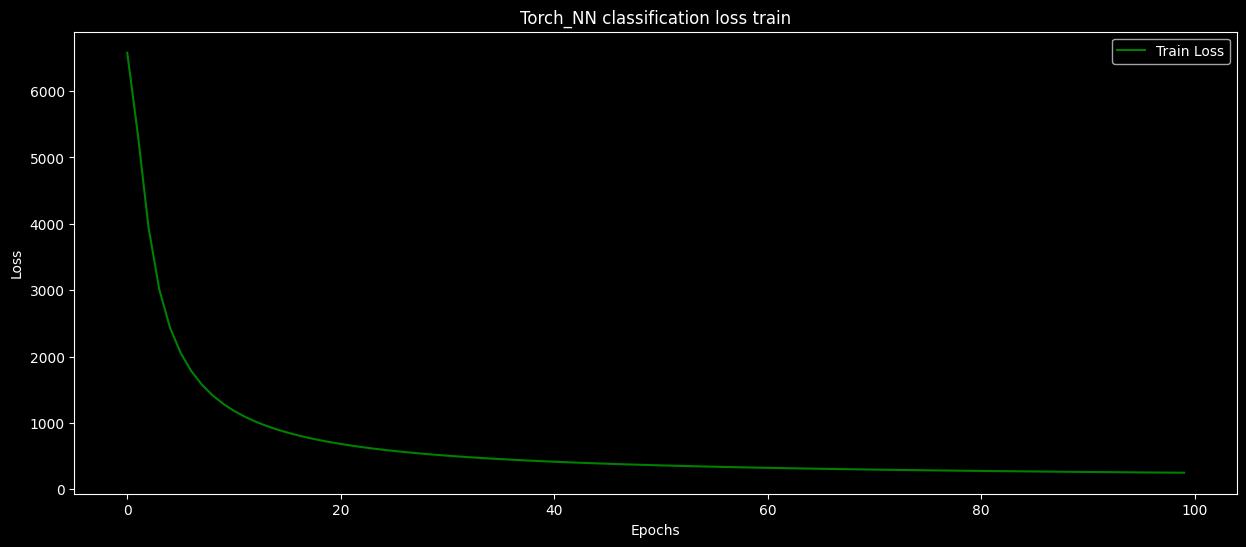

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         label='Train Loss',
         color='g',
         linestyle="-"
         )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Torch_NN classification loss train")
plt.legend()
plt.show()

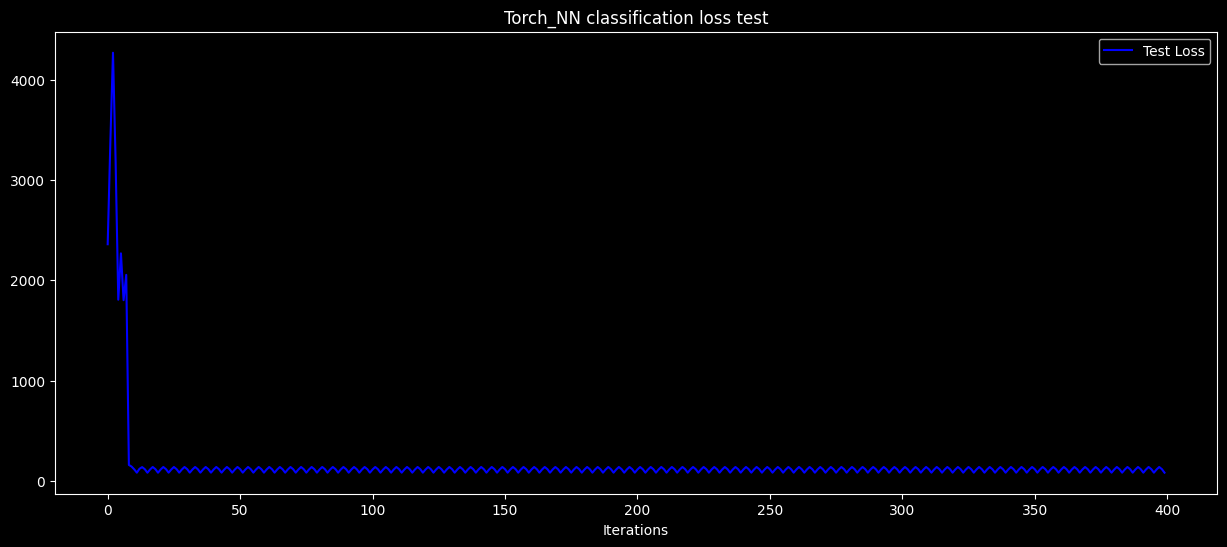

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(losses_test)),
         losses_test,
         label='Test Loss',
         color='b',
         linestyle="-"
         )
plt.title('Test Loss over Iterations')
plt.xlabel('Iterations')
plt.title("Torch_NN classification loss test")
plt.legend()
plt.show()

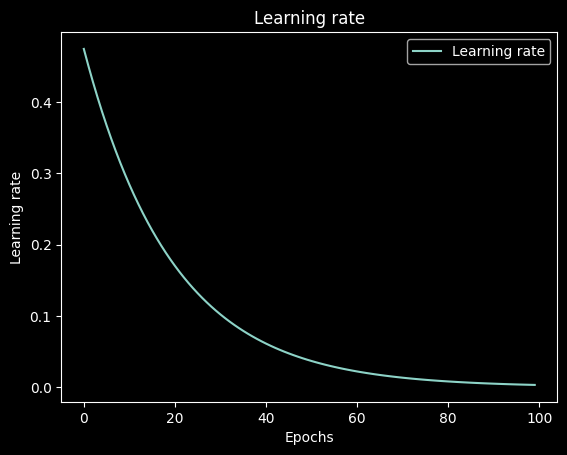

In [ ]:
plt.plot(lrs, label='Learning rate')
plt.title('Learning rate')
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()
plt.show()